## Introduction {#sec-intro}
 
As part of this blog post we will be uncovering the inner workings of CLIP - [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020) by looking at it's PyTorch implementation. For a gentle introduction to CLIP, please refer to [part-1](https://amaarora.github.io/posts/2023-03-06_Understanding_CLIP.html) of the blog.

In this blog post, we will be covering the following with references to further resources where necessary:

1. *Data download and preparation*
2. *CLIP architecture in code* 
3. *CLIP image encoder*
4. *CLIP text encoder* 
5. *CLIP loss function*

> From the [open clip repository](https://github.com/mlfoundations/open_clip), I found the most complex part to be data preparation. That in itself could be a separate blog post, and therefore, I have only covered it partly here as the main focus is to look at the CLIP architecture. **As part of this blog post we are going to assume that there is some magic function that can read the input images and texts and return tensors of shape `[N, 3, 224, 224]` & `[N, 77]` respectively, where $N$ is the batch size.**

## Prerequisites

As part of this blog post, I am going to assume that the reader has a good understanding of the ResNet architecture (@resnet) and Vision Transformer (@vit).

I am also going to assume that the reader also has a good basic understanding of CLIP after having read [part-1](https://amaarora.github.io/posts/2023-03-06_Understanding_CLIP.html) of this blog series. 

If the reader would like a refresher on the ResNet architecture, please refer to the following video from paper reading group, that I hosted at [Weights and Biases](https://wandb.ai/).

Also, the authors use Vision Transformer as one of the backbones in Image Encoder. For complete understanding of ViT with PyTorch code implementation, refer to my previous blog post (in collaboration with [Dr Habib Bukhari](https://twitter.com/dr_hb_ai)) - [Vision Transformer](https://amaarora.github.io/posts/2021-01-18-ViT.html). We won't be covering ViT architecture as part of this blog post.

For the text encoder, the authors used the GPT-2 architecture. I have previously covered the entirety of the model with PyTorch code implementation at [The annotated GPT-2](https://amaarora.github.io/posts/2020-02-18-annotatedGPT2.html).

Now, with prerequisites and introductions out of the way, let's get started with the first item which is **"Data download and preparation".**

## Data download using `img2dataset` and preparation using `webdataset`

Before we can start training any models, we need data. In this part of the blog post we are looking at data preparation part of CLIP. Remember, that CLIP was trained on 400M (image, text) pairs. 

From the paper: 

*We create a new dataset of 400 million (image, text) pairs and demonstrate that a simplified version of ConVIRT trained from scratch, which we call CLIP, for Contrastive Language-Image Pre-training, is an efficient method of learning from natural language supervision.*

So, how does one create these image text pairs in practice? One of the easiest ways to train CLIP using Open CLIP is to generate the dataset in the form of `webdataset` using `img2dataset`.

**We will only be creating a tiny version consisting of only 1,000 (image, text) and not the complete 400M dataset used in CLIP.**

In [9]:
%%time
# !pip install img2dataset 
from img2dataset import download
import shutil
import os

output_dir = os.path.abspath("sample")

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

download(
    processes_count=os.cpu_count(),
    thread_count=os.cpu_count()*2,
    url_list="/home/ubuntu/GIT_REPOS/data/img2dataset/tests/test_files/test_1000.parquet",
    image_size=256,
    output_folder=output_dir,
    output_format="webdataset",
    input_format="parquet",
    url_col="URL",
    caption_col="TEXT",
    enable_wandb=False,
    number_sample_per_shard=100, 
    distributor="multiprocessing",
)

Starting the downloading of this file
Sharding file number 1 of 1 called /home/ubuntu/GIT_REPOS/data/img2dataset/tests/test_files/test_1000.parquet

0it [00:00, ?it/s]


File sharded in 10 shards


10it [00:31,  3.19s/it]


worker  - success: 0.840 - failed to download: 0.150 - failed to resize: 0.010 - images per sec: 12 - count: 100
total   - success: 0.840 - failed to download: 0.150 - failed to resize: 0.010 - images per sec: 12 - count: 100
worker  - success: 0.850 - failed to download: 0.140 - failed to resize: 0.010 - images per sec: 12 - count: 100
total   - success: 0.845 - failed to download: 0.145 - failed to resize: 0.010 - images per sec: 23 - count: 200
worker  - success: 0.850 - failed to download: 0.140 - failed to resize: 0.010 - images per sec: 8 - count: 100
total   - success: 0.847 - failed to download: 0.143 - failed to resize: 0.010 - images per sec: 23 - count: 300
worker  - success: 0.850 - failed to download: 0.150 - failed to resize: 0.000 - images per sec: 9 - count: 100
total   - success: 0.848 - failed to download: 0.145 - failed to resize: 0.007 - images per sec: 30 - count: 400
worker  - success: 0.840 - failed to download: 0.160 - failed to resize: 0.000 - images per sec: 1

So it takes ~35 seconds to create the tiny dataset on my 8 core machine. Please refer to [img2dataset](https://github.com/rom1504/img2dataset) for information on other available (image, text) pair datasets.

But, what do the downloads look like? Let's find out. 

In [10]:
import numpy as np
from pathlib import Path

np.array(sorted(list(Path('./sample/').glob('*tar'))))

array([PosixPath('sample/00000.tar'), PosixPath('sample/00001.tar'),
       PosixPath('sample/00002.tar'), PosixPath('sample/00003.tar'),
       PosixPath('sample/00004.tar'), PosixPath('sample/00005.tar'),
       PosixPath('sample/00006.tar'), PosixPath('sample/00007.tar'),
       PosixPath('sample/00008.tar'), PosixPath('sample/00009.tar')],
      dtype=object)

As we can see above, the script from `img2dataset` downloads `{00000...00009).tar` files. What's in these `.tar` files? Answer lies in the documentation of [webdataset](https://webdataset.github.io/webdataset/). I won't be covering more details as part of this blog post as we have a lot to cover stil!

## Training

Now, to train a CLIP model of your choice on a single GPU, simply clone the [Open Clip repository](https://github.com/mlfoundations/open_clip) and run the following command in your terminal in the `src/` directory:

```python
python -m training.main \
    --save-frequency 1 \
    --zeroshot-frequency 1 \
    --train-data="/home/ubuntu/GIT_REPOS/amaarora.github.io/posts/sample/{00000..00009}.tar" \
    --warmup 10 \
    --batch-size=16 \
    --lr=1e-3 \
    --wd=0.1 \
    --epochs=30 \
    --workers=8 \
    --model RN50 \
    --train-num-samples 852
```

This should kick off training on your machine. Now, that we can train CLIP models on our own machines, let's look at some of the details of training scrip and the CLIP architecture. 

## CLIP Architecture

![Summary of CLIP approach](../images/clip.png){#fig-clip fig-align="center" width=500}

From @fig-clip, we can see that we have a text encoder and image encoder. These encoders are responsible for taking in the image and the text and and converting them to an embedding space.

As mentioned in @sec-intro, we will assume that there is some magic function that can read the `.tar` files and return tensors of shape `[1, 3, 224, 224]` for each image, and `[1, 77]`, for each text. 

These inputs then get encoded to embedding space using image and text encoder respectively. 

The image encoder encodes images to embeddings $I_1, I_2, I_2 ... I_N$, and the text encoder encodes respective image captions to $T_1, T_2, T_3 ... T_N$.

Let's start by looking at the inputs and outputs of the overall CLIP model.

First, we load the config, as part of this blog post we will work with `ResNet-50` architecture as an example. So, let's start by loading the corresponding config.

In [11]:
import json, torch
from open_clip.model import CLIP

In [12]:
with open('../../open_clip/src/open_clip/model_configs/RN50.json') as o:
    cfg = json.load(o)
cfg

{'embed_dim': 1024,
 'vision_cfg': {'image_size': 224,
  'layers': [3, 4, 6, 3],
  'width': 64,
  'patch_size': None},
 'text_cfg': {'context_length': 77,
  'vocab_size': 49408,
  'width': 512,
  'heads': 8,
  'layers': 12}}

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CLIP(**cfg).to(device)
image = torch.randn(1, 3, 224, 224).to(device)
text  = torch.randint(low=0, high=cfg['text_cfg']['vocab_size'], size=(1, 77)).to(device)
image_features, text_features, logit_scale   = model(image, text)
image_features.shape, text_features.shape, logit_scale

(torch.Size([1, 1024]),
 torch.Size([1, 1024]),
 tensor(14.2857, device='cuda:0', grad_fn=<ExpBackward0>))

As can be seen above, the model expects `image` and `text` as inputs where in this case:

```python
image = torch.randn(1, 3, 224, 224).to(device)
text  = torch.randint(low=0, high=cfg['text_cfg']['vocab_size'], size=(1, 77)).to(device)
```

You might recognize image shape easily - it represents 1 image with 3 channels (RGB) and (H,W) = 224.
For text, each text is tokenized to max length 77. The integer numbers represent `token_id` with max value of `cfg['text_cfg']['vocab_size']`.

Makes sense so far? 

As for the outputs, the model returns three outputs - `image_features`, `text_features` and `logit_scale`. 

`logit_scale` has been covered in more detail in @sec-contrastive-loss of this blog post. For now, think of it as a learnable parameter during model training. 

As for `image_features` & `text_features`, these are the respective embeddings $I_1, I_2, I_2 ... I_N$, and the text encoder encodes respective image captions to $T_1, T_2, T_3 ... T_N$ with reference to @fig-clip.

Next, let's look at the respective architectures of Image and Text encoders in more detail. 

## Image Encoder {#sec-img-encoder}

From the paper:

*We consider two different architectures for the image encoder. For the first, we use ResNet-50 (@resnet) as the base architecture for the image encoder due to its widespread adoption and proven performance. We make several modifications to the original version using the ResNetD improvements from @bag_of_tricks and the antialiased rect-2 blur pooling from @blurpool. We also replace the global average pooling layer with an attention pooling mechanism. The attention pooling is implemented as a single layer of “transformer-style” multi-head QKV attention where the query is conditioned on the global average-pooled representation of the image. For the second architecture, we experiment with the recently introduced Vision Transformer (ViT) (@vit). We closely follow their implementation with only the minor modification of adding an additional layer normalization to the combined patch and position embeddings before the transformer and use a slightly different initialization scheme.*

### Modified ResNet

Let's start with the first architecture. 

*For the first, we use ResNet-50 (@resnet) as the base architecture for the image encoder due to its widespread adoption and proven performance. We make several modifications to the original version using the ResNetD improvements from @bag_of_tricks and the antialiased rect-2 blur pooling from @blurpool. We also replace the global average pooling layer with an attention pooling mechanism. The attention pooling is implemented as a single layer of “transformer-style” multi-head QKV attention where the query is conditioned on the global average-pooled representation of the image.*

There are 3 major changes as mentioned to the ResNet architecture in CLIP: 

- There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
- Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
- The final pooling layer is a QKV attention instead of an average pool

#### ResNet stem {#sec-resnet-stem}

Let's look at all of them one by one in code. First, we start with *There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.*

![Overview of ResNet architecture](../images/resnet-arch.png){#fig-resnet-arch fig-align="center" width=500}

In the vanilla ResNet architecture, the stem consists of a 7x7 stride-2 convolution. This is what the stem looks like in the vanilla ResNet architecture. 

```python
class VanillaResNet:
    def __init__(...):
        self.stem = nn.Conv2d(in_chans, inplanes, kernel_size=7, stride=2, padding=3, bias=False)
```

However, in the paper @bag_of_tricks, where at the time, the authors raised *ResNet-50’s top-1 validation accuracy from 75.3% to 79.29% on ImageNet*. From the paper, one of the tweaks used in the architecture: 

*A 7 × 7 convolution is 5.4 times more expensive than a 3 × 3 convolution. So this tweak replacing the 7 × 7 convolution in the input stem with three conservative 3 × 3 convolutions.*

![Overview of ResNet tweak](../images/resnet-tweak.png){#fig-resnet-tweak fig-align="center"}

In code this looks like: 

```python 
class ModifiedResNet:
    def __init__(...):
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.act2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.act3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)


    def stem(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.avgpool(x)
        return x
    
    def forward(self, x):
        x = self.stem(x)
```    

#### Blur Pool

The next change is to use `BlurPooling` - *Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1*. This change has been adopted from @blurpool.

In this section I will introduce BlurPooling and share how it is implemented in the `ModifiedResNet` architecture. 

From the research paper, 

*Modern convolutional networks are not shiftinvariant, as small input shifts or translations can cause drastic changes in the output. Commonly used downsampling methods, such as max-pooling, strided-convolution, and averagepooling, ignore the sampling theorem. The wellknown signal processing fix is anti-aliasing by low-pass filtering before downsampling.*

Blur Pooling in CLIP has been implemented inside the `Bottleneck` block as below: 

```python 

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.stem = create_stem() # stem consists of 3 3x3 convs instead of 1 7x7 stride-2 conv
        self.downsample = None
        self.stride = stride
        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x
        out = self.stem()
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.act3(out)
        return out
 ```

Now the blurring occurs in `downsample`. Previously, as can be seen in @fig-resnet-arch, this downsample layer would be a stride-2 $1x1$ convolution. 

In `ModifiedResnet`, this downsample consists of: 

```python
self.downsample = nn.Sequential(OrderedDict([
        ("-1", nn.AvgPool2d(stride)),
        ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
        ("1", nn.BatchNorm2d(planes * self.expansion))
    ]))
```

Where, the convolution is stride-1. 

The blurring occurs in `nn.AvgPool2d(stride)`. How? See example below:

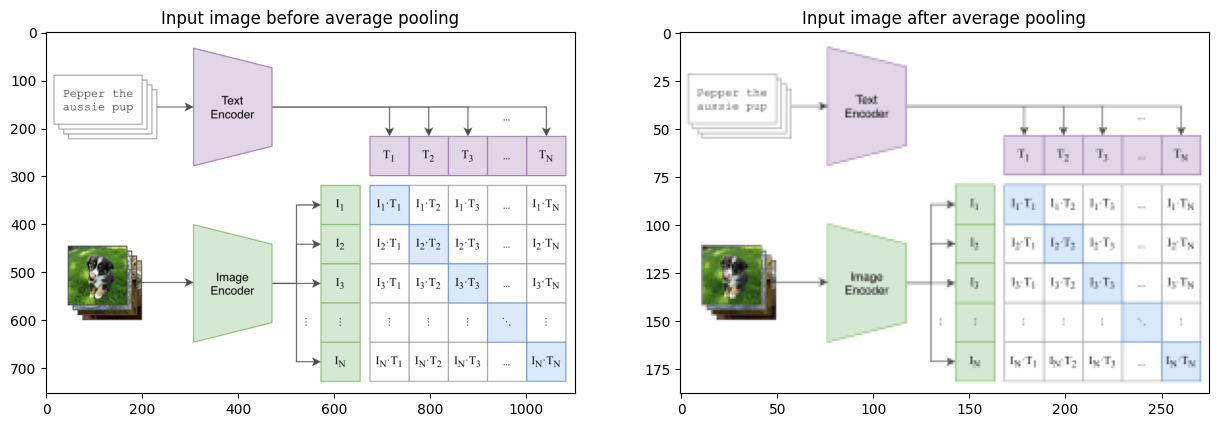

In [19]:
import torch.nn as nn 
from PIL import Image
import numpy as np 
import torch
import matplotlib.pyplot as plt

pool = nn.AvgPool2d(kernel_size=2)
img  = np.array(Image.open('../images/clip.png'))
x    = torch.tensor(img, dtype=torch.float64).permute(2, 0, 1)
out  = pool(pool(x))

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(x.int().permute(1,2,0))
ax[0].set_title("Input image before average pooling");
ax[1].imshow(out.int().permute(1,2,0))
ax[1].set_title("Input image after average pooling");

As can be seen above, passing the input image through a `nn.AvgPool2d` blurs the image, and therefore, anti-aliases the input as per @blurpool. As a result, the resulting model is translation invariant. 

#### Final pooling layer

This brings us to the final change in `ModifiedResnet`. 

The last change in the network architecture is to use QKV attention instead of an average pool. From the paper:

*We also replace the global average pooling layer with an attention pooling mechanism. The attention pooling is implemented as a single layer of “transformer-style” multi-head QKV attention where the query is conditioned on the global average-pooled representation of the image.*

In [14]:
import torch
import torch.nn as nn

class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0.,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]

As can be seen from the code above, we perform multi head self-attention from @attention, on `x`. One key thing to note above in the `forward` method is : 

```python
x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
```

This corresponds to *"query is conditioned on the global average-pooled representation of the image"* from the paper because the final output that is returned is `x[0]` and `x[0]` is global average pooled representation of the image. 

### Modified ViT

From the paper:

*For the second architecture, we experiment with the recently introduced Vision Transformer (ViT) (@vit). We closely follow their implementation with only the minor modification of adding an additional layer normalization to the combined patch and position embeddings before the transformer and use a slightly different initialization scheme.*

Since the architecture is very similar to vanilla Vision Transformer, with a very minor change of adding LayerNorm after combining Patch embeddings and positional embeddings, I will not be covering the architecture in detail in this blog post. 

For reference to ViT, please refer to my previous blog post that covers the architecture in detail with PyTorch code implementation - [Vision Transformer](https://amaarora.github.io/posts/2021-01-18-ViT.html)

Having covered both Image encoders used in CLIP architecture, it is now time to move on to the text encoder. 

## Text Encoder

In this section, let's look at the text encoder of CLIP architecture. From the paper: 

*The text encoder is a Transformer (@attention) with the architecture modifications described in Radford et al. (2019). As a base size we use a 63M-parameter 12layer 512-wide model with 8 attention heads. The transformer operates on a lower-cased byte pair encoding (BPE) representation of the text with a 49,152 vocab size (Sennrich et al., 2015). For computational efficiency, the max sequence length was capped at 76. The text sequence is bracketed with [SOS] and [EOS] tokens and the activations of the highest layer of the transformer at the [EOS] token are treated as the feature representation of the text which is layer normalized and then linearly projected into the multi-modal embedding space. Masked self-attention was used in the text encoder to preserve the ability to initialize with a pre-trained language model or add language modeling as an auxiliary objective, though exploration of this is left as future work.*

I have previously covered the complete GPT-2 architecture used as text encoder in my previous blog post at [The annotated GPT-2](https://amaarora.github.io/posts/2020-02-18-annotatedGPT2.html) and therefore, won't be covering it here in this blog post. 

## Contrastive Loss  {#sec-contrastive-loss}

One thing that I was most interested in when I started to write the CLIP blog post was to look at Contrastive Loss and understand it in PyTorch code. 

In this section, that is exactly what we will be doing. 

If you remember from @sec-img-encoder, the images get encoded as image features to shape `torch.Size([16, 1024])` and texts get encoded to text features of shape `torch.Size([16, 1024])`. 

Let's look at the inputs and outputs of `ClipLoss` before implementing ourselves.

In [15]:
import torch
import torch.nn.functional as F
import numpy as np 
import torch.nn as nn
from open_clip.loss import ClipLoss

In [16]:
image_features = torch.randn(16, 1024)
text_features  = torch.randn(16, 1024)
loss_fn        = ClipLoss()
logit_scale    = nn.Parameter(torch.tensor(np.log(1/0.07)))
loss = loss_fn(image_features, text_features, logit_scale)
loss

tensor(134.1310, grad_fn=<DivBackward0>)

One thing you'll notice is that the ClipLoss expects a parameter called `logit_scale`. Now, what is this `logit_scale` parameter? 

From the paper: 

*The learnable temperature parameter $τ$ was initialized to the equivalent of 0.07 from (@rotation_equivalent_cnn) and clipped to prevent scaling the logits by more than 100 which we found necessary to prevent training instability.*

But, rather than being initialised to $0.07$, this temperature parameter $τ$ get's initialized as `nn.Parameter(torch.tensor(np.log(1/0.07)))`. For further explanation, see this issue [here](https://github.com/openai/CLIP/issues/46).

Now, having looked at the inputs and outputs and also `logit_scale`, it is time to look at the source code. Remember contrastive loss and what it does from [part-1](https://amaarora.github.io/posts/2023-03-06_Understanding_CLIP.html#summary-with-pseudo-code) of the blog post? As a quick revision, let me re-post the image here too. 

![Cosine similarity between text and image features](../images/cosine_similarity.png){#fig-cosine-similarity}

Contrastive loss is trying to maximise the cosine similarity on the diagonal and minimise it elsewhere. But, how? In pseudo-code this looked something like: 

```python
# symmetric loss function 
labels = np.arange(n) 
loss_i = cross_entropy_loss(logits, labels, axis=0) 
loss_t = cross_entropy_loss(logits, labels, axis=1) 
loss = (loss_i + loss_t)/2
```

Once, we have logits, which is the $8 x 8$ matrix as in @fig-cosine-similarity above, we calculate Cross Entropy Loss once for `axis=0` and once for `axis=1`, this way, we are trying to match the diagonal to corresponding image and text because the labels are aligned on both the axis.

But, how does this look like in code? Let's see. 

In [17]:
class ClipLoss(nn.Module):
    def __init__(
            self,
    ):
        super().__init__()

    def get_ground_truth(self, device, num_logits) -> torch.Tensor:
        labels = torch.arange(num_logits, device=device, dtype=torch.long)
        return labels

    def get_logits(self, image_features, text_features, logit_scale):
        logits_per_image = logit_scale * image_features @ text_features.T
        logits_per_text = logit_scale * text_features @ image_features.T        
        return logits_per_image, logits_per_text

    def forward(self, image_features, text_features, logit_scale, output_dict=False):
        device = image_features.device
        logits_per_image, logits_per_text = self.get_logits(image_features, text_features, logit_scale)
        labels = self.get_ground_truth(device, logits_per_image.shape[0])
        total_loss = (
            F.cross_entropy(logits_per_image, labels) +
            F.cross_entropy(logits_per_text, labels)
        ) / 2
        return {"contrastive_loss": total_loss}

In [18]:
image_features = torch.randn(16, 1024)
text_features  = torch.randn(16, 1024)
loss_fn        = ClipLoss()
logit_scale    = nn.Parameter(torch.tensor(np.log(1/0.07)))
loss = loss_fn(image_features, text_features, logit_scale)
loss

{'contrastive_loss': tensor(140.2225, grad_fn=<DivBackward0>)}

So, how does the above implementation match pseudo-code? 

Let's start with labels. Since the labels are aligned, that is the $0th$ image on `axis=0` corresponds to $0th$ text on `axis=1`, therefore, we can just say that `labels = torch.arange(num_logits, device=device, dtype=torch.long)`. In this case the value of labels comes out to be `tensor([ 0,  1,  2,  3,  4,  5,  6,  7], device='cuda:0')` based on @fig-cosine-similarity. By minimising Cross Entropy loss for these labels once for `axis=0` and once for `axis=1`, we are making sure that cosine-similarity on the diagonal is maximum and lower otherwise. 

In code (as opposed to pseudo-code), rather than minimising cross entropy for `axis=0`, and `axis=1`, we calculate: 

```python 
    logits_per_image = logit_scale * image_features @ text_features.T
    logits_per_text = logit_scale * text_features @ image_features.T    
```

This is same as calculating logits once for `axis=1`, and once for `axis=0`, therefore, our total loss is: 

```python 
    total_loss = (
        F.cross_entropy(logits_per_image, labels) +
        F.cross_entropy(logits_per_text, labels)
    ) / 2
```

This is equivalent to pseudo code from paper: 
```python
    labels = np.arange(n) 
    loss_i = cross_entropy_loss(logits, labels, axis=0) 
    loss_t = cross_entropy_loss(logits, labels, axis=1) 
    loss = (loss_i + loss_t)/2
```

## Conclusion

As part of this blog post I built upon [part-1](https://amaarora.github.io/posts/2023-03-06_Understanding_CLIP.html) of this blog series on CLIP. 

We also briefly looked at data preparation as (image, text) pairs for CLIP training using `img2dataset` and data loading using `webdataset` packages. 

We took a deep dive into the Image Encoder section and looked at all the three tweaks in `ModifiedResnet` compared to vanilla ResNet architecture. 

Finally, we also took a deep dive in contrastive loss and compared the actual PyTorch implementation with pseudo-code from the CLIP research paper. 

If you enjoyed reading this blog post, please consider subscribing to my blog for more!